In [1]:
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

c:\Codes\Learning\Lang_graph\venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [3]:

res = llm.invoke("hi").content

In [4]:
res

'Hello! How can I help you today?'

In [6]:
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

In [7]:
class ChatState(MessagesState):
    summary: str

In [9]:

def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = llm.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [10]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = llm.invoke(messages)
    return {"messages": [response]}

In [11]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [12]:

builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")

In [13]:

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

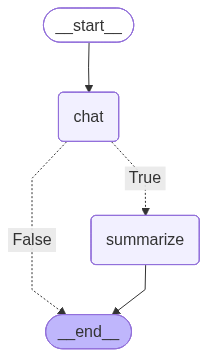

In [14]:

graph

In [15]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [16]:

# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [17]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='da49a930-7b3d-4e10-a3b3-4ffdbb02c08e')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum Physics, also known as Quantum Mechanics, is a fundamental theory in phy


In [18]:

run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='da49a930-7b3d-4e10-a3b3-4ffdbb02c08e'), AIMessage(content='Quantum Physics, also known as Quantum Mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It\'s one of the two pillars of modern physics (along with Einstein\'s theory of Relativity) and is renowned for its mind-bending concepts that challenge our classical understanding of reality.\n\nHere are the core ideas and principles of Quantum Physics:\n\n1.  **Quantization:**\n    *   **The Idea:** Energy, momentum, angular momentum, and other quantities are not continuous but come in discrete "packets" or "quanta."\n    *   **Example:** Light, which we perceive as a continuous wave, is actually composed of discrete energy packets called **photons**. An atom can only absorb or emit energy in specific, fixed amounts. This was first proposed by Max Planck to ex

In [19]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='da49a930-7b3d-4e10-a3b3-4ffdbb02c08e'), AIMessage(content='Quantum Physics, also known as Quantum Mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It\'s one of the two pillars of modern physics (along with Einstein\'s theory of Relativity) and is renowned for its mind-bending concepts that challenge our classical understanding of reality.\n\nHere are the core ideas and principles of Quantum Physics:\n\n1.  **Quantization:**\n    *   **The Idea:** Energy, momentum, angular momentum, and other quantities are not continuous but come in discrete "packets" or "quanta."\n    *   **Example:** Light, which we perceive as a continuous wave, is actually composed of discrete energy packets called **photons**. An atom can only absorb or emit energy in specific, fixed amounts. This was first proposed by Max Planck to ex

In [20]:

run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='da49a930-7b3d-4e10-a3b3-4ffdbb02c08e'), AIMessage(content='Quantum Physics, also known as Quantum Mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It\'s one of the two pillars of modern physics (along with Einstein\'s theory of Relativity) and is renowned for its mind-bending concepts that challenge our classical understanding of reality.\n\nHere are the core ideas and principles of Quantum Physics:\n\n1.  **Quantization:**\n    *   **The Idea:** Energy, momentum, angular momentum, and other quantities are not continuous but come in discrete "packets" or "quanta."\n    *   **Example:** Light, which we perceive as a continuous wave, is actually composed of discrete energy packets called **photons**. An atom can only absorb or emit energy in specific, fixed amounts. This was first proposed by Max Planck to ex